# NWA suntans: inspect momentum balances


In [1]:
import os

import numpy as np
#import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
if False:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=10)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

In [3]:
ds, grd = nwa.load_surf()
zarr_grad = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_gradients")
ds_grad = xr.open_zarr(zarr_grad)

zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low")
low = xr.open_zarr(zarr)
zarr_grad = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low_gradients")
low_grad = xr.open_zarr(zarr_grad)

f = pin.geo.coriolis(grd.yv)

---
## inspect one point

In [11]:
idx = nwa.find_point_index(*nwa.moorings["W310"], grd)

In [14]:
def get_mbalance(ds, ds_grad, f):

    mbal = xr.merge(
        [ds[["uc", "vc"]], 
         ds_grad[["detadx", "detady"]],
        ]
    )
    
    # reinterpolate on a regular timeline
    mbal = mbal.resample(dict(time="1H")).interpolate()

    mbal["x_acc"] = mbal["uc"].differentiate("time", datetime_unit="s")
    mbal["y_acc"] = mbal["vc"].differentiate("time", datetime_unit="s")
    mbal["x_coriolis"] = -f*mbal["vc"]
    mbal["y_coriolis"] =  f*mbal["uc"]

    g = 9.81
    mbal["x_gradp"] = g*mbal["detadx"]
    mbal["y_gradp"] = g*mbal["detady"]

    return mbal

In [15]:
mbal = get_mbalance(ds.isel(Nc=idx), ds_grad.isel(Nc=idx), f.isel(Nc=idx)).compute()
mbal_low = get_mbalance(low.isel(Nc=idx), low_grad.isel(Nc=idx), f.isel(Nc=idx)).compute()

In [16]:
def plot_mbal(mbal):

    fig, axes = plt.subplots(2,1, figsize=(10,10), sharex=True)

    ax = axes[0]
    terms = ["x_acc", "x_coriolis", "x_gradp"]
    for v in terms:
        mbal[v].plot(ax=ax, alpha=.5, label=v)

    r = sum([mbal[v] for v in terms]).rename("residual")
    r.plot(ax=ax, color="k", label="residual")

    ax.grid()
    ax.set_title("x momentum balance")
    ax.legend()


    ax = axes[1]

    terms = ["y_acc", "y_coriolis", "y_gradp"]
    for v in terms:
        mbal[v].plot(ax=ax, alpha=.5, label=v)

    r = sum([mbal[v] for v in terms]).rename("residual")
    r.plot(ax=ax, color="k", label="residual")

    ax.grid()
    ax.set_title("y momentum balance")
    ax.legend()

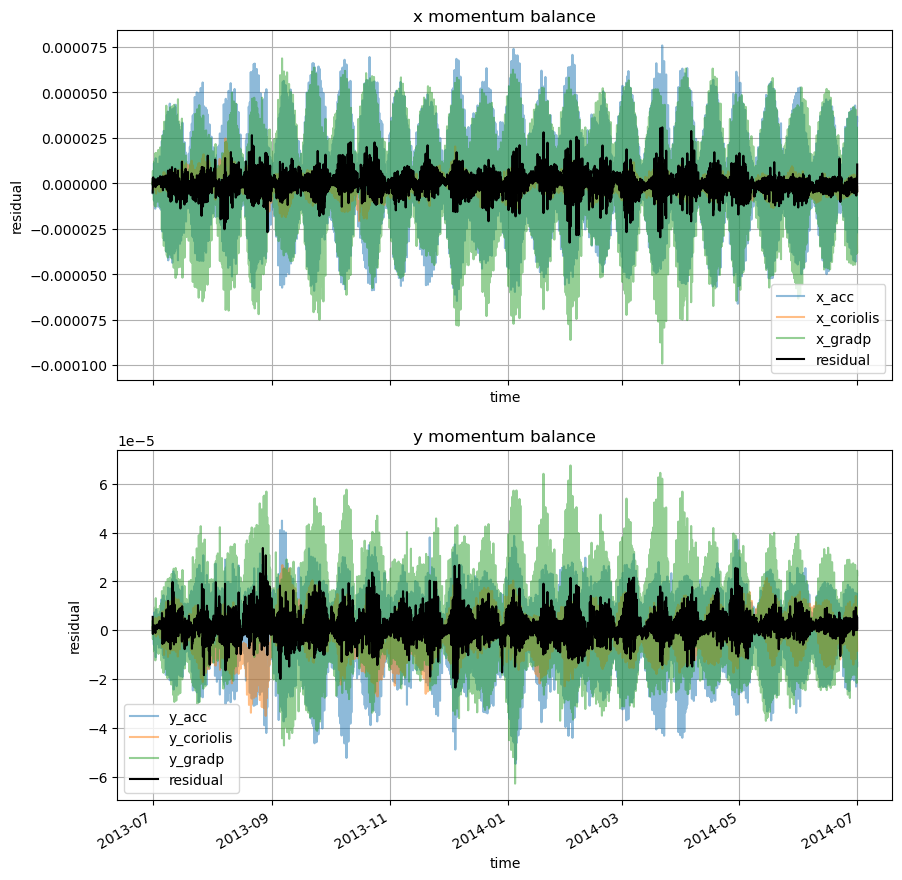

In [17]:
plot_mbal(mbal)

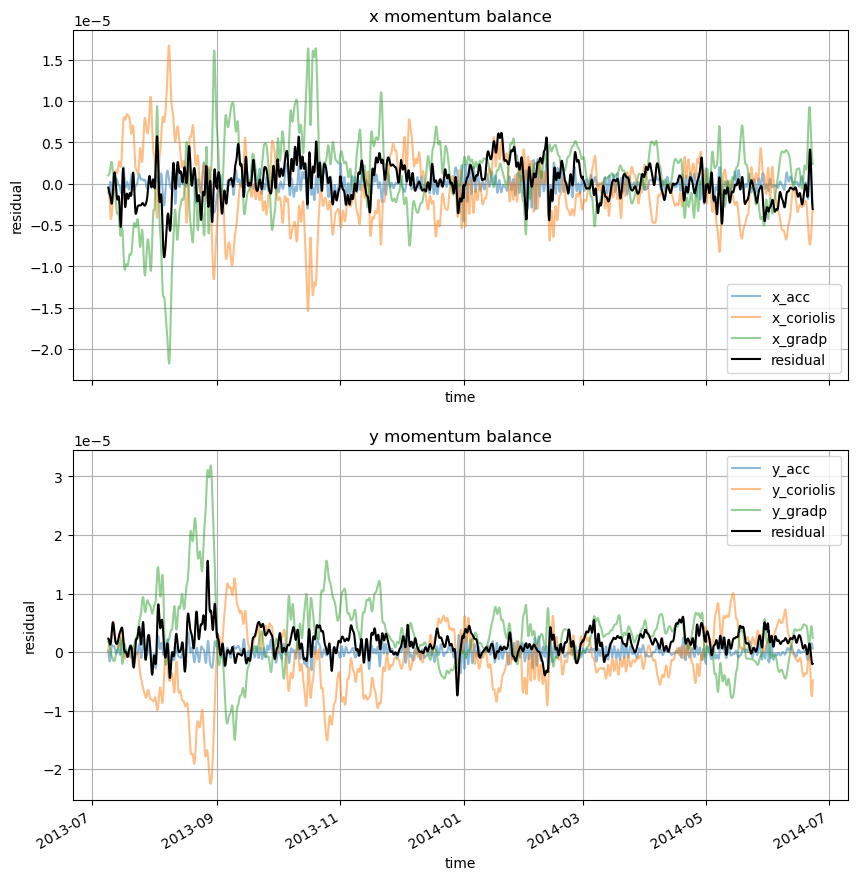

In [18]:
plot_mbal(mbal_low)

---

In [13]:
cluster.close()